# Generating 1D Simulation and Data from a 3D Model

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os
    
import discretize

from SimPEG import (
    maps
)
from SimPEG.electromagnetics import frequency_domain as fdem

import sys
sys.path.append("../")
from inversion_toolkit.model_functions import get_1d_model, generate_survey

In [38]:
write_output = True

## Setup 3D Model

In [39]:
resistivity_surface = 1000
resistivity_middle = 10
resistivity_deep = 100
resistivity_air = 1e8

## Forward Modelling Mesh

the mesh has 624 cells


C:\Users\sabri\AppData\Local\Temp\ipykernel_42516\969901675.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncx = int(np.diff(core_domain_x) / csx)
C:\Users\sabri\AppData\Local\Temp\ipykernel_42516\969901675.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncz = int(np.diff(core_domain_z) / csz)


<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

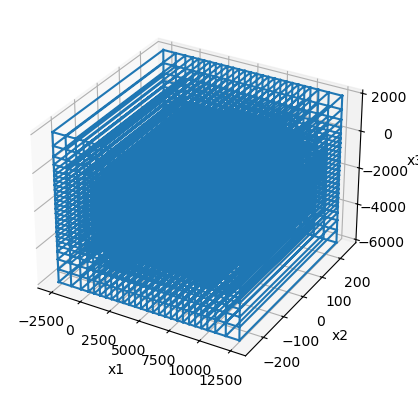

In [40]:
csx = 500  # cell size for the horizontal direction
csz = 250  # cell size for the vertical direction
pf = 1.3  # expansion factor for the padding cells

npadx = 3  # number of padding cells in the x-direction
npady = 0  # number of padding cells in the y-direction
npadz = 4  # number of padding cells in the z-direction

core_domain_x = np.r_[0, 10000]  # extent of uniform cells in the x-direction
core_domain_z = np.r_[-4000, 0]  # extent of uniform cells in the z-direction

# number of cells in the core region
ncx = int(np.diff(core_domain_x) / csx)
ncz = int(np.diff(core_domain_z) / csz)

# create a 3D tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)],
        [(csx, npady, -pf), (csx, 1), (csx, npady, pf)],
        [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)],
    ]
)

mesh.x0 = np.r_[
    -mesh.h[0][: npadx].sum(), -mesh.h[1].sum()/2, -mesh.h[2][: npadz + ncz].sum()
]

print("the mesh has {} cells".format(mesh.nC))
mesh.plot_grid()

In [41]:
#Save the mesh
# mesh.save(file_name="../meshes/3d_mesh.json")

In [42]:
mesh

TensorMesh: 624 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     26     -2,593.50     12,593.50    500.00  1,098.50    1.30
   y      1       -250.00        250.00    500.00    500.00    1.00
   z     24     -6,010.77      2,010.78    250.00    714.03    1.30

## 2D Inversion Mesh

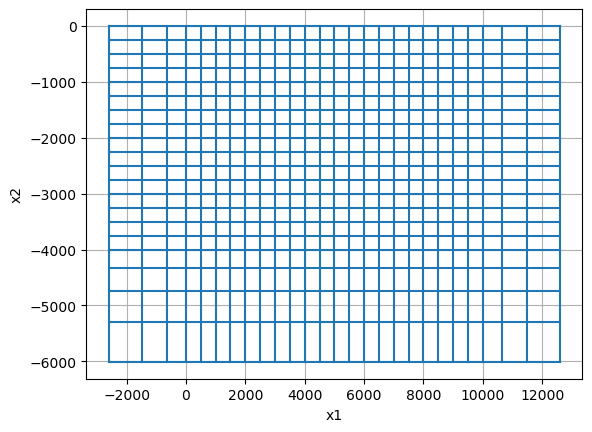

In [43]:
inversion_mesh_2d = discretize.TensorMesh([mesh.h[0], mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh_2d.x0 = [-inversion_mesh_2d.h[0][mesh.cell_centers_x <= 0].sum(), -inversion_mesh_2d.h[1].sum()]
ax = inversion_mesh_2d.plot_grid()

In [44]:
#save the inversion mesh
# inversion_mesh_2d.save(file_name="../meshes/inversion_mesh_2d.json")

## Mapping

In [45]:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.h[0], mesh.h[2]], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface


mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, resistivity_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh_2d.nC
    )
)

## True Model

In [46]:
# Define interface parameters
interfaces = [
    {
        'z_shallow': -500,
        'z_deep': -1000,
        'x_dip': np.r_[5000, 9000]
    },
    {
        'z_shallow': -1000,
        'z_deep': -2500,
        'x_dip': np.r_[2000, 7000]
    }
]

In [47]:
def interface(x, inferfaces=interfaces):

    boundaries = []
    for i, keys in enumerate(interfaces):
        z1, z2, x_dip = keys.values()
        temp = np.zeros_like(x)
        if i ==0:
            temp[x < x_dip[0]] = z1
        dipping_unit = (x >= x_dip[0]) & (x <= x_dip[1])
        x_dipping = (-(z1 - z2) / (x_dip[1]- x_dip[0])) * x[dipping_unit]
        x_dipping = x_dipping - x_dipping[0] + z1
        temp[dipping_unit] = x_dipping
        temp[x > x_dip[1]] = z2
        boundaries.append(temp)

    return boundaries[0], boundaries[1]

(-4000.0, 0.0)

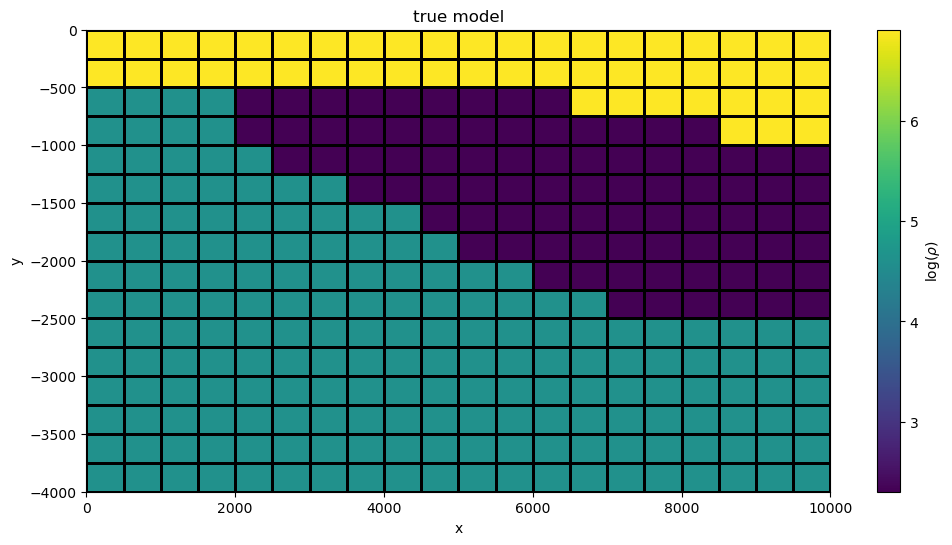

In [48]:
m_true = np.log(resistivity_deep) * np.ones(inversion_mesh_2d.nC)
interface_1, interface_2 = interface(inversion_mesh_2d.gridCC[:, 0])
m_true[inversion_mesh_2d.gridCC[:, 1] > interface_2] = np.log(resistivity_middle)
m_true[inversion_mesh_2d.gridCC[:, 1] > interface_1] = np.log(resistivity_surface)

fig, ax = plt.subplots(1, 1, figsize=(12,6))
clim = np.r_[np.log(10), np.log(1000)]
cb = plt.colorbar(inversion_mesh_2d.plot_image(m_true, ax=ax, grid=True, clim=clim)[0], ax=ax)
cb.set_label(r"$\log(\rho)$")
ax.set_title("true model")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])
# ax.minorticks_on()
# ax.grid(True, color='k', which="both")

In [49]:
# save model
# np.save('../models/2d-model-array.npy', m_true)

## 1D Data Collection

Please check the model_fucntions.py in the inversion_toolkit folder for further documentation on the functions used to generate survey and obtaining 1d model.

In [50]:
frequencies = np.logspace(-1, 4, 15)
moment = 1
x_positions = np.arange(0, 10500, 500)

dpreds = []
for i, x in enumerate(x_positions):
    survey = generate_survey(frequencies=frequencies, x_position=x, moment=1)
    layer_thicknesses, log_resistivity_map, log_resistivity_model, _ = get_1d_model(x, m_true=m_true, inversion_mesh_2d=inversion_mesh_2d)
    sim = fdem.Simulation1DLayered(
        survey=survey,
        thicknesses=layer_thicknesses,
        rhoMap=log_resistivity_map,
    )
    dpreds.append(sim.dpred(log_resistivity_model))

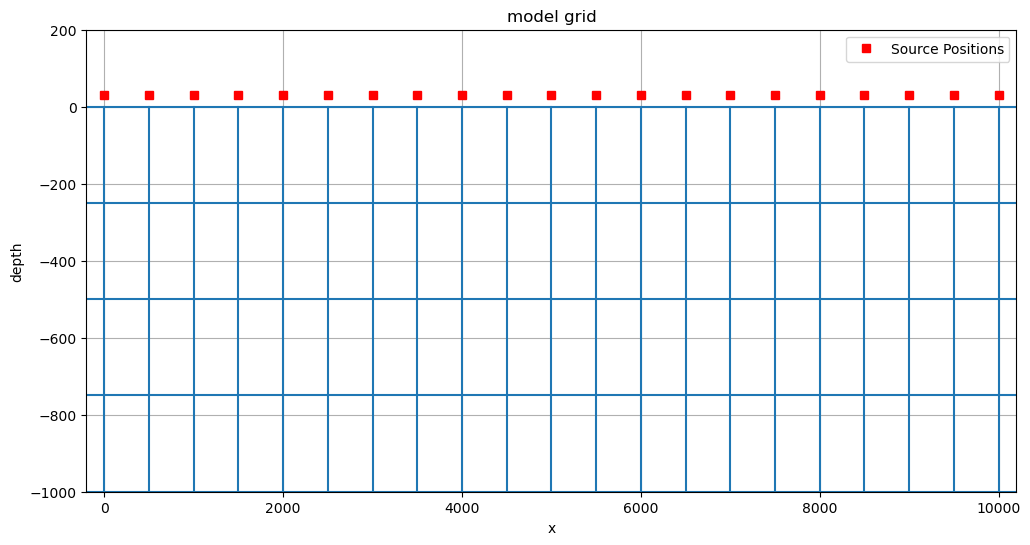

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
clim = np.r_[np.log(10), np.log(1000)]
inversion_mesh_2d.plot_grid(ax=ax)
cb.set_label(r"$\log(\rho)$")
ax.plot(x_positions, 30*np.ones_like(x_positions), 'rs', label="Source Positions")
# ax.plot(receiver_locations[:,0], receiver_locations[:,2], 'bs', label="Receiver Positions")
ax.set_title("model grid")
ax.set_ylabel("depth")
ax.set_xlabel("x")
ax.set_xlim([-200, 10.2e3])
# ax.set_xlim([-10, 20])
ax.set_ylim([-1.0e3, 200])
ax.legend()
plt.show()

### Plot 1d data for a certain location

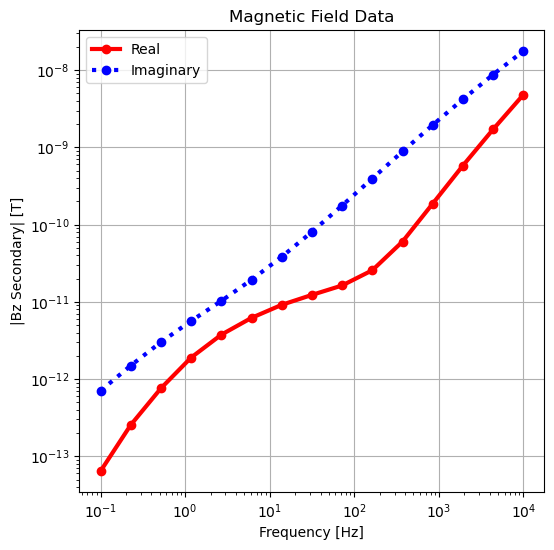

In [52]:
location_index = 20
d  = dpreds[location_index]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.loglog(frequencies, abs(d[0::2]), "r-o", lw=3)
ax.loglog(frequencies, abs(d[1::2]), "b:o", lw=3)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("|Bz Secondary| [T]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.grid()
plt.show()

### Save Data

In [53]:
if write_output:
    # Get the directory of the current notebook
    notebook_dir = os.getcwd()
    dir_path = os.path.join(notebook_dir, "3d_simulation_data")
    
    # Ensure the directory exists, create it if not
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    np.random.seed(222)
    noise_level = 0.05 # Change this

    dobs = []

    for d in dpreds:
        noise = noise_level * np.abs(d) * np.random.rand(len(d))
        d += noise
        dobs.append(d[0::2]) # add real data
        dobs.append(d[1::2]) # add imaginary data
    
    fname = os.path.join(dir_path, "em3dfm_1d_data_1DLayered.txt")
    np.savetxt(
        fname,
        np.c_[frequencies, *dobs], #needed to modify this line
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )